### Carga de datos

In [45]:
#Librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
#Mostrar los graficos
%matplotlib inline

In [47]:
# Cargamos los datos
try:
    df = pd.read_csv('../DATA/Raw_Data/Data_Pool.csv')
    print('Archivo Cargado')
    print(df.head(2)) 
except Exception as e:
    print(f'Error en la lectura del archivo: {e}')

Archivo Cargado
      Device            Time, Hour   PH  ORP  Salinity  Temperature  \
0  Device 01  18/01/2024, 00:08:34  7.5  644      5181           25   
1  Device 01  18/01/2024, 00:10:35  6.3  742      5240           25   

   Flow status  
0            1  
1            1  


In [48]:
#Vista general de los datos con todos los dispositivos
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141102 entries, 0 to 141101
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Device       141102 non-null  object 
 1   Time, Hour   141102 non-null  object 
 2   PH           141102 non-null  float64
 3   ORP          141102 non-null  int64  
 4   Salinity     141102 non-null  int64  
 5   Temperature  141102 non-null  int64  
 6   Flow status  141102 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 7.5+ MB
None

Estadísticas descriptivas:
                  PH            ORP       Salinity    Temperature  \
count  141102.000000  141102.000000  141102.000000  141102.000000   
mean     -165.849238     389.765524    4435.838925   -2362.903878   
std      1304.943138    1607.346796     812.908034    4265.998757   
min     -9999.000000   -9999.000000   -9999.000000   -9999.000000   
25%         7.100000     593.000000    3859.000000       7.0000

In [49]:
#Renombramos la columa 'Time, Hour' y  pasar a Datetime format
df = df.rename(columns={'Time, Hour': 'Time'})
df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y, %H:%M:%S')
df['Time'].head(2)

0   2024-01-18 00:08:34
1   2024-01-18 00:10:35
Name: Time, dtype: datetime64[ns]

In [50]:
#Vamos a hacer la limpieza individualmente esta vez:
device = df['Device'].unique()[0]
df_device = df[df['Device'] == device].copy()

print(f"Analizando el dispositivo: {device}")
print(df_device.shape)
print(df_device.head())

Analizando el dispositivo: Device 01
(20256, 7)
      Device                Time   PH  ORP  Salinity  Temperature  Flow status
0  Device 01 2024-01-18 00:08:34  7.5  644      5181           25            1
1  Device 01 2024-01-18 00:10:35  6.3  742      5240           25            1
2  Device 01 2024-01-18 00:14:37  6.3  760      5233           25            0
3  Device 01 2024-01-18 00:28:42  6.5  774      5240           24            0
4  Device 01 2024-01-18 00:31:34  6.3  764      5253           24            0


### Limpieza de datos 1.

In [51]:
#Nulos

df_device.isnull().sum()

Device         0
Time           0
PH             0
ORP            0
Salinity       0
Temperature    0
Flow status    0
dtype: int64

In [52]:
duplicates = df_device.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")

Número de filas duplicadas: 38


In [53]:
# Eliminar duplicados
df_device.drop_duplicates(inplace=True)
duplicates = df_device.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")

Número de filas duplicadas: 0


In [54]:
# Resetear
df_device.reset_index(drop=True, inplace=True)

print("\nDimensiones del DataFrame después de la limpieza:")
print(df_device.shape)


Dimensiones del DataFrame después de la limpieza:
(20218, 7)


In [55]:
print(df_device.describe())

                                Time            PH           ORP  \
count                          20218  20218.000000  20218.000000   
mean   2024-04-06 03:32:35.162033920  -1199.527493   -983.711099   
min              2024-01-18 00:01:34  -9999.000000  -9999.000000   
25%    2024-02-19 06:30:00.249999872      4.200000    548.000000   
50%              2024-03-31 07:06:38      6.700000    710.000000   
75%              2024-05-17 08:46:17      7.500000    837.000000   
max              2024-07-18 11:06:22      9.220000   1129.000000   
std                              NaN   3257.745005   3969.028486   

           Salinity   Temperature   Flow status  
count  20218.000000  20218.000000  20218.000000  
mean    5334.630824     17.616876      0.383322  
min        0.000000      0.000000      0.000000  
25%     5239.000000     12.000000      0.000000  
50%     5341.000000     17.000000      0.000000  
75%     5427.000000     24.000000      1.000000  
max     6237.000000     31.000000    

### Visualizacion de datos pre-tratamiento

In [56]:
parameters = ['PH', 'ORP', 'Salinity', 'Temperature']

In [57]:
df_device['PH']

0           7.50
1           6.30
2           6.30
3           6.50
4           6.30
          ...   
20213       8.08
20214       8.08
20215       8.10
20216   -9999.00
20217   -9999.00
Name: PH, Length: 20218, dtype: float64

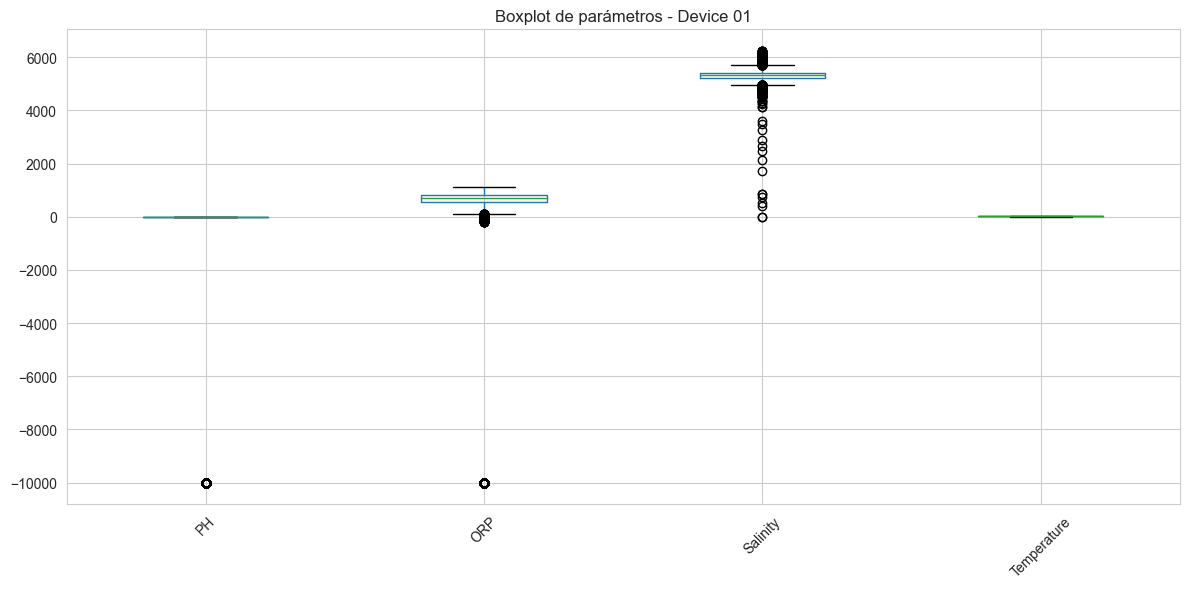

In [58]:
# Diagrama de cajas de los parámetros para ver si hay que tratar los outliers ante
plt.figure(figsize=(12, 6))
df_device[parameters].boxplot()
plt.title(f'Boxplot de parámetros - {device}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

| Parámetro        | Valores Estándar | Mínimo Peligroso  | Máximo Peligroso  |
|----------------- |------------------|-------------------|-------------------|
| pH               | 7.2 - 7.6        | < 6.8             | > 8.0             |
| ORP (mV)         | 650 - 750        | < 600             | > 900             |
| Salinidad (ppm)  | 2700 - 3400      | < 2000            | > 6000            |

- pH: Valores fuera del rango 6.8 - 8.0 pueden causar irritación en piel y ojos, además de afectar la eficacia de los desinfectantes.
- ORP: Por debajo de 600 mV, la desinfección puede ser inadecuada. Por encima de 900 mV, puede haber un exceso de desinfectantes que podría ser irritante.
Salinidad: Niveles muy bajos reducen la eficacia del sistema de cloración salina, mientras que niveles muy altos pueden causar corrosión en equipos metálicos y ser incómodos para los nadadores.



In [59]:
'''# Método IQR para eliminar outliers
def outliers(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        limiteQ1 = Q1 - 1.5 * IQR
        limiteQ3 = Q3 + 1.5 * IQR 
        df_clean = df_clean[(df_clean[column] >= limiteQ1) & (df_clean[column] <= limiteQ3)]
    return df_clean

# Se eliminan los valores de -9999 que parecen provenir de error
param = ['PH', 'ORP', 'Salinity', 'Temperature']
df_1 = df_device[
    (~(df_device[param] == -9999).any(axis=1)) &
    (df_device['PH'] >= 6.5) &
    (df_device['PH'] <= 8.2) &
    (df_device['ORP'] >= 600) &
    (df_device['ORP'] <= 750) &
    (df_device['Salinity'] >= 2000) &
    (df_device['Salinity'] <= 6000)
]

# Llamamos a la función para eliminar outliers
df_clean = outliers(df_1, param)

# Cuantos eliminados
print(f"Filas dataset original del {device}: {len(df_device)}")
print(f"Filas después de eliminar errores y valores fuera de rango: {len(df_1)}")
print(f"Filas después de eliminar outliers: {len(df_clean)}")

# Estadísticas descriptivas de los datos limpios
print("\nEstadísticas descriptivas de los datos limpios:")
print(df_clean[param].describe())

# Porcentaje de datos conservados
percent_kept = (len(df_clean) / len(df_device)) * 100
print(f"\nPorcentaje de datos conservados: {percent_kept:.2f}%")'''

'# Método IQR para eliminar outliers\ndef outliers(df, columns):\n    df_clean = df.copy()\n    for column in columns:\n        Q1 = df[column].quantile(0.25)\n        Q3 = df[column].quantile(0.75)\n        IQR = Q3 - Q1\n        limiteQ1 = Q1 - 1.5 * IQR\n        limiteQ3 = Q3 + 1.5 * IQR \n        df_clean = df_clean[(df_clean[column] >= limiteQ1) & (df_clean[column] <= limiteQ3)]\n    return df_clean\n\n# Se eliminan los valores de -9999 que parecen provenir de error\nparam = [\'PH\', \'ORP\', \'Salinity\', \'Temperature\']\ndf_1 = df_device[\n    (~(df_device[param] == -9999).any(axis=1)) &\n    (df_device[\'PH\'] >= 6.5) &\n    (df_device[\'PH\'] <= 8.2) &\n    (df_device[\'ORP\'] >= 600) &\n    (df_device[\'ORP\'] <= 750) &\n    (df_device[\'Salinity\'] >= 2000) &\n    (df_device[\'Salinity\'] <= 6000)\n]\n\n# Llamamos a la función para eliminar outliers\ndf_clean = outliers(df_1, param)\n\n# Cuantos eliminados\nprint(f"Filas dataset original del {device}: {len(df_device)}")\npr

In [60]:
# Método IQR para eliminar outliers
def outliers(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        limiteQ1 = Q1 - 1.5 * IQR
        limiteQ3 = Q3 + 1.5 * IQR 
        df_clean = df_clean[(df_clean[column] >= limiteQ1) & (df_clean[column] <= limiteQ3)]
    return df_clean

# Se eliminan los valores de -9999 que parecen provenir de error
param = ['PH', 'ORP', 'Salinity', 'Temperature']
df_1 = df_device[
    (~(df_device[param] == -9999).any(axis=1)) &
    (df_device['PH'] >= 6) &
    (df_device['PH'] <= 8.5) 
]

# Llamamos a la función para eliminar outliers
df_clean = outliers(df_1, param)

# Cuantos eliminados
print(f"Filas dataset original del {device}: {len(df_device)}")
print(f"Filas después de eliminar errores y valores fuera de rango: {len(df_1)}")
print(f"Filas después de eliminar outliers: {len(df_clean)}")

# Estadísticas descriptivas de los datos limpios
print("\nEstadísticas descriptivas de los datos limpios:")
print(df_clean[param].describe())

# Porcentaje de datos conservados
percent_kept = (len(df_clean) / len(df_device)) * 100
print(f"\nPorcentaje de datos conservados: {percent_kept:.2f}%")

Filas dataset original del Device 01: 20218
Filas después de eliminar errores y valores fuera de rango: 11629
Filas después de eliminar outliers: 11150

Estadísticas descriptivas de los datos limpios:
                 PH           ORP      Salinity   Temperature
count  11150.000000  11150.000000  11150.000000  11150.000000
mean       7.244085    688.657130   5269.836951     19.517668
std        0.557461    106.765943    140.290480      6.550740
min        6.000000    380.000000   4888.000000      0.000000
25%        6.800000    618.000000   5176.000000     13.000000
50%        7.400000    699.000000   5285.000000     21.000000
75%        7.600000    766.000000   5363.000000     25.000000
max        8.500000    998.000000   5651.000000     31.000000

Porcentaje de datos conservados: 55.15%


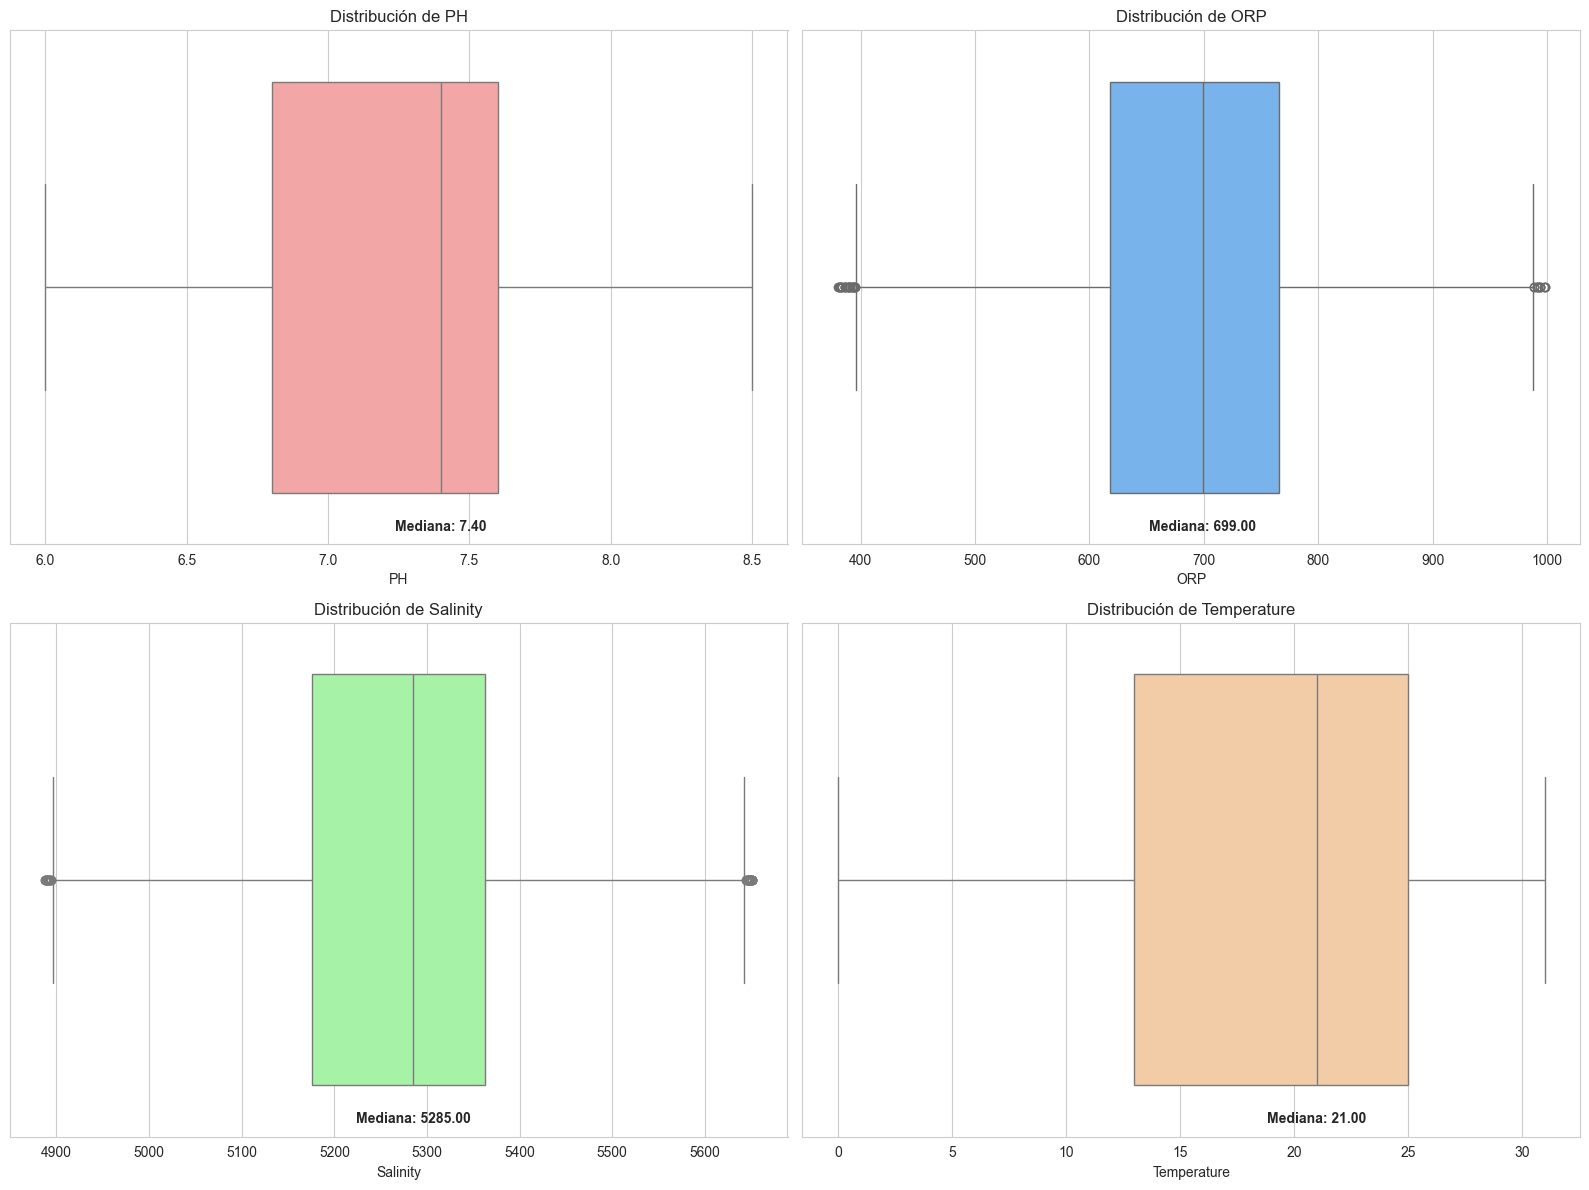

In [61]:
# Estilo de seaborn
sns.set_style("whitegrid")

# Subplots para cada parámetro
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Aplanar el array de axes para facilitar la iteración

# iagrama de cajas
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
for ax, param, color in zip(axes, param, colors):
    sns.boxplot(x=df_clean[param], ax=ax, color=color)
    ax.set_title(f'Distribución de {param}')
    ax.set_xlabel(param)
    
    median = df_clean[param].median()
    ax.text(median, 0.02, f'Mediana: {median:.2f}', 
            horizontalalignment='center', verticalalignment='bottom',
            transform=ax.get_xaxis_transform(), fontweight='bold')
plt.tight_layout()
plt.show()

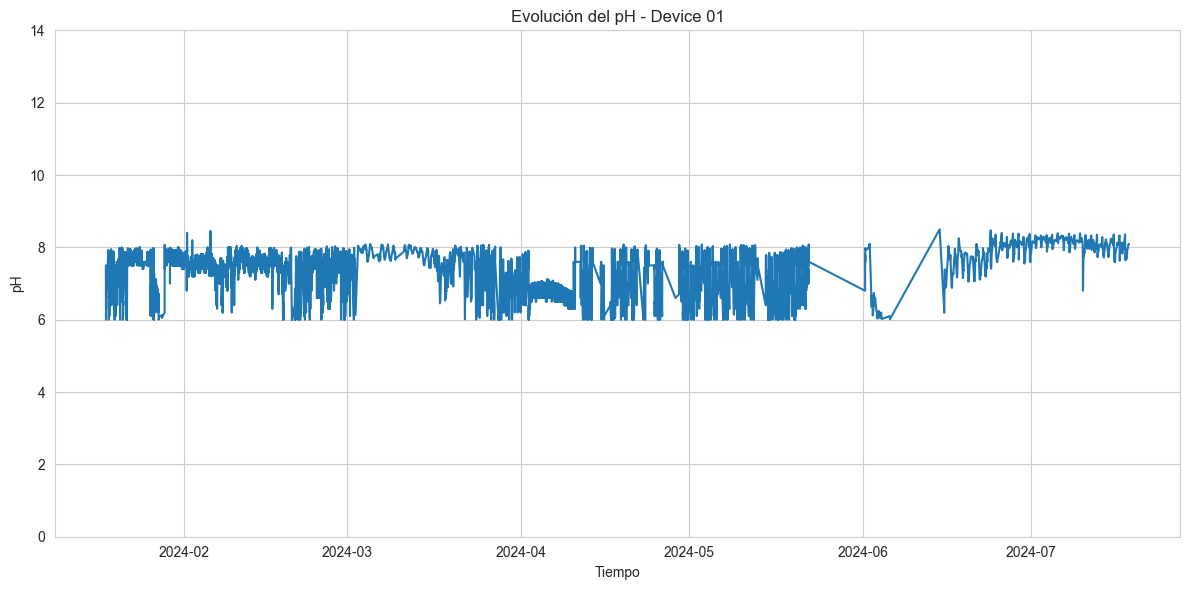

In [62]:
#Grafica PH vd Time
df_device = df_clean.sort_values('Time')

# Gráfico de pH vs tiempo
plt.figure(figsize=(12, 6))
plt.plot(df_device['Time'], df_device['PH'])
plt.title(f'Evolución del pH - {device}')
plt.xlabel('Tiempo')
plt.ylabel('pH')
plt.ylim(0,14)
plt.grid(True)
plt.tight_layout()
plt.show()

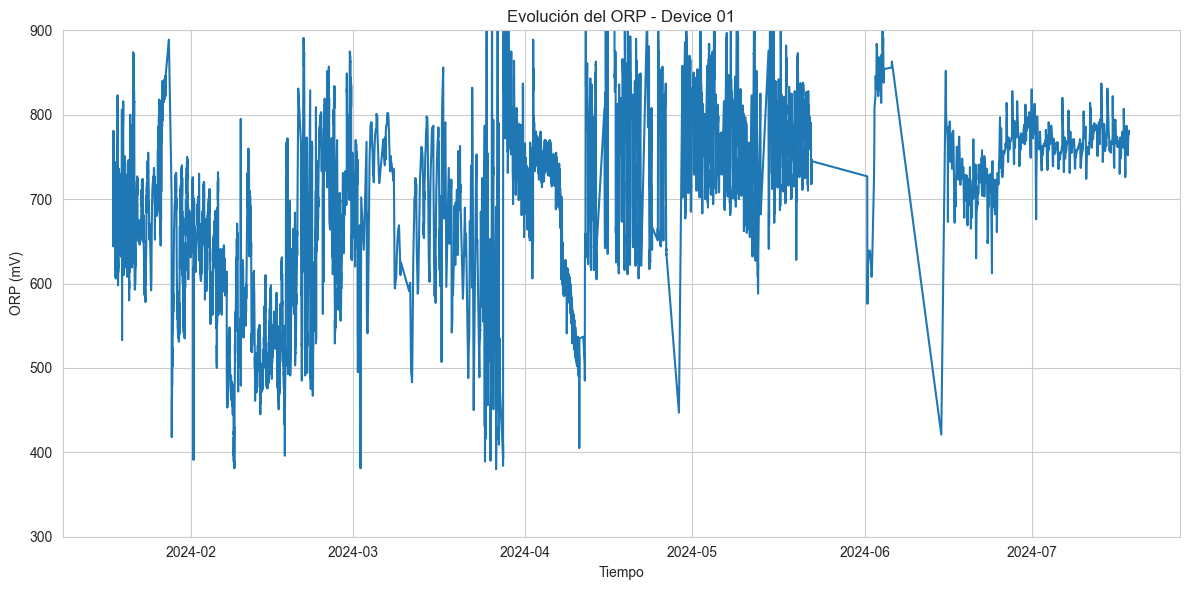

In [63]:
# Gráfico de ORP vs tiempo
plt.figure(figsize=(12, 6))
plt.plot(df_device['Time'], df_device['ORP'])
plt.title(f'Evolución del ORP - {device}')
plt.xlabel('Tiempo')
plt.ylabel('ORP (mV)')
plt.ylim(300,900)
plt.grid(True)
plt.tight_layout()
plt.show()

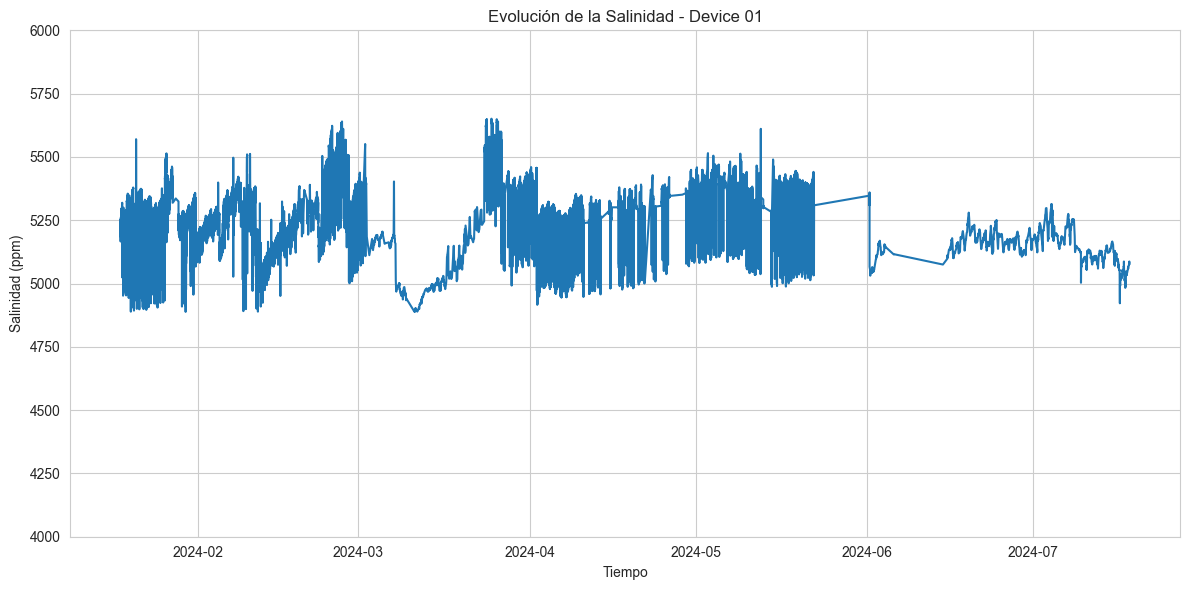

In [64]:
# Gráfico de Salinidad vs tiempo
plt.figure(figsize=(12, 6))
plt.plot(df_device['Time'], df_device['Salinity'])
plt.title(f'Evolución de la Salinidad - {device}')
plt.xlabel('Tiempo')
plt.ylabel('Salinidad (ppm)')
plt.ylim(4000,6000)
plt.grid(True)
plt.tight_layout()
plt.show()

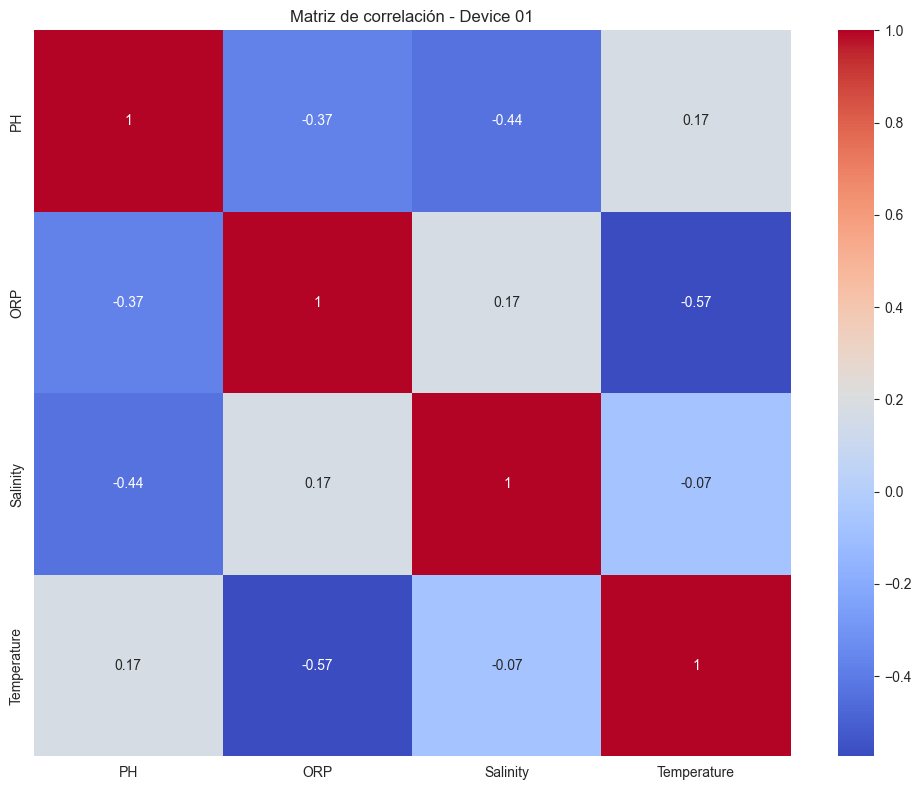

In [65]:
# Matriz de correlación
corr_matrix = df_device[parameters].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f'Matriz de correlación - {device}')
plt.tight_layout()
plt.show()

         Device                Time   PH  ORP  Salinity  Temperature  \
1454  Device 01 2024-01-24 00:04:19  7.6  689      5280           26   
1455  Device 01 2024-01-24 00:05:20  7.6  690      5177           26   
1456  Device 01 2024-01-24 00:14:23  7.6  690      5282           26   
1457  Device 01 2024-01-24 00:15:23  7.6  692      5045           26   
1458  Device 01 2024-01-24 00:22:52  7.6  692      5252           27   

      Flow status  
1454            1  
1455            1  
1456            1  
1457            1  
1458            1  
                                Time           PH          ORP     Salinity  \
count                           1063  1063.000000  1063.000000  1063.000000   
mean   2024-01-24 12:38:50.714957568     7.821402   595.455315  4772.988711   
min              2024-01-24 00:02:00     6.900000   201.000000  3656.000000   
25%              2024-01-24 07:05:04     7.400000   596.000000  4043.000000   
50%              2024-01-24 12:53:57     7.500000   

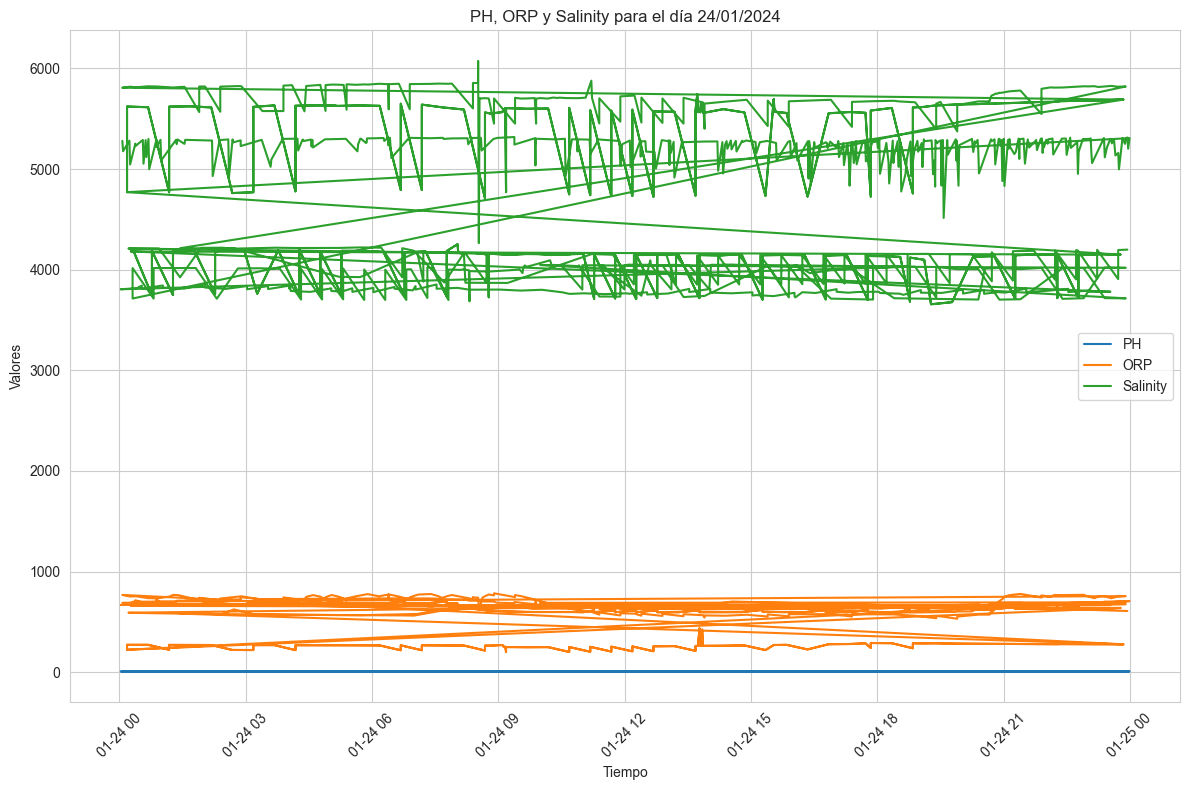

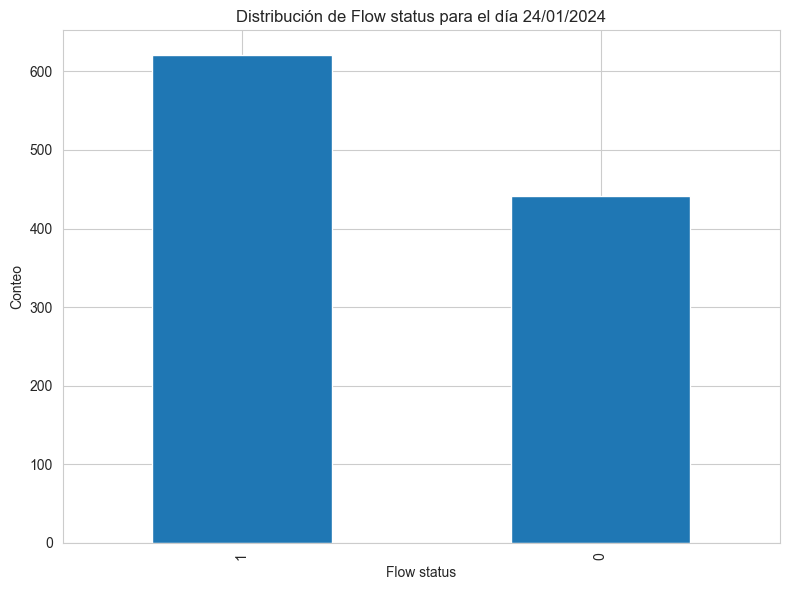

In [66]:
dia_especifico = '24/01/2024'
datos_dia = df[df['Time'].dt.strftime('%d/%m/%Y') == dia_especifico]

# Mostrar las primeras filas de los datos filtrados
print(datos_dia.head())

# Mostrar un resumen estadístico de los datos numéricos
print(datos_dia.describe())

# Crear un gráfico de líneas para PH, ORP y Salinity
plt.figure(figsize=(12, 8))
plt.plot(datos_dia['Time'], datos_dia['PH'], label='PH')
plt.plot(datos_dia['Time'], datos_dia['ORP'], label='ORP')
plt.plot(datos_dia['Time'], datos_dia['Salinity'], label='Salinity')
plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.title(f'PH, ORP y Salinity para el día {dia_especifico}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar la distribución de Flow status
flow_status_counts = datos_dia['Flow status'].value_counts()
plt.figure(figsize=(8, 6))
flow_status_counts.plot(kind='bar')
plt.title(f'Distribución de Flow status para el día {dia_especifico}')
plt.xlabel('Flow status')
plt.ylabel('Conteo')
plt.tight_layout()
plt.show()